# SHAPE enabled-RNA-RNA interaction prediction

In [1]:
TAIR_genome = '../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna'
TAIR_gff_NCBI = '../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz'
TAIR_gff_ensm = '../../../DataBase/TAIR/Arabidopsis_thaliana.TAIR10.38.gff3.gz'
TAIR_gff = TAIR_gff_NCBI

import os
import pandas as pd
from subprocess import Popen, PIPE

INTARNA_ARGS = "-n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0 "
PATH_INTARNA = './IntaRNA/src/bin/'
INTARNA_BIN = os.path.join(PATH_INTARNA, 'IntaRNA') 

## Run plfold on query RNA U1

In [2]:
query_id = "ENSRNA049495626-T1-U1"
query_fasta = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa'
query_react = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.react'
query_react_idless = '../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.noid.react'


## Run IntaRNA

In [3]:
def run_intaRNA_precomputed_access(query_fa, target_fa, query_id, target_id, acc_lunp=None, out_suffix=''):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    cmd = 'IntaRNA --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    if acc_lunp is not None:
        cmd += '--qAccFile={} '.format(lunp_shape)
        params += '--qAcc=P '
    
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling intARNA\n{}\n{}\n".format(out, err))

    #print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap

## Extract exon junctions of single gene from gff file

In [4]:
import subprocess

def gene_gff_to_df(gene_name):
    gene_gff = gene_name+'.gff'
    gzip_cmd = "gunzip -c {} | grep 'gene={};'  > {}".format(TAIR_gff, gene_name, gene_gff)
    print(gzip_cmd)
    subprocess.call(gzip_cmd, shell=True)

    df_gff = pd.read_csv(gene_gff, sep='\t',header=None,comment="#",
                     names=['seqname','source','feature','start','end','score','strand','frame','attribute'])

    #print(df_gff)
    df_genes = df_gff[df_gff['feature']=='gene']
    if len(df_genes) > 1:
        print ("BIG WARNING: multiple isoforms(?) found & IGNORED for gene", gene_name)
        print ("Genes with same name (isoforms?)")
    #print (df_genes.iloc[:,0:7])
    df_gff_exons = df_gff[df_gff['feature']=='CDS'].sort_values('start')
    df_gff_exons_uniqs = df_gff_exons.drop_duplicates(subset=['start','end']).copy()
    return df_gff_exons_uniqs, df_genes.iloc[0:1]
# gene_gff_to_df('ACT1')

In [5]:
def df_gff_to_bed_fasta(df, gene_name):
    bed_df = df['seqname'].map(str) + '\t' + df['start'].map(str) + '\t' +\
        df['end'].map(str) + '\t' +\
        gene_name+'-'+df.index.map(str) + '\t' +\
        '1\t' + df['strand'].map(str)
    bed_str = '\n'.join(bed_df.values)
    print(bed_str)
    bed_file = gene_name+'.bed'
    fasta_genes_genomic = gene_name + '-genomic.fa'
    with open(bed_file, 'w') as bed_out:
        bed_out.write(bed_str)
    bed_cmd = 'bedtools getfasta -fi {} -bed {} -fo {} -s -name'.format(
        TAIR_genome, bed_file, fasta_genes_genomic)
    p = Popen(bed_cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    print(bed_cmd)
    if (err):
        raise RuntimeError('Error in bedtools\n{}\n{}'.format(out, err))
    #print (out)
    print ('bedtools getfasta on ', fasta_genes_genomic)
    return fasta_genes_genomic

In [6]:
def compute_relative_locs(df_gff, gene_start, gene_end, strand):
    if (strand == '+'):
        df_gff.loc[:,'relative-start']= df_gff['start'] - gene_start+1
        df_gff.loc[:,'relative-end'] =  df_gff['end'] - gene_start+1
        ret_arr = [(r['relative-start'],r['relative-end']) for ir, r in df_gff.iterrows()]        
        
    elif (strand == '-'):
        df_gff.loc[:,'relative-start']= -df_gff['start'] + gene_end+1
        df_gff.loc[:,'relative-end'] =  -df_gff['end'] + gene_end+1
        ret_arr = [(r['relative-end'],r['relative-start']) for ir, r in df_gff.iterrows()]        
    else:
        raise RuntimeError('Strand type error')
    return sorted(ret_arr)



In [7]:
import math
import numpy as np
def parse_spotprobs(file1, file2, suffixes=['_STD','_SHAPE'],skip_0_0_spot=True):
    print("parse_spotprobs")
    df1 = pd.read_csv(file1,sep=';')
    df2 = pd.read_csv(file2,sep=';')
    df12 = pd.merge(df1, df2, on='spot', suffixes=suffixes)
    if skip_0_0_spot:
        df12 = df12[df12['spot']!='0&0']
    df12['probability_SHAPE/probability_STD'] = (df12['probability_SHAPE']+1e-50)/(df12['probability_STD']+1e-50)
    df12['log2(probability_SHAPE/probability_STD)'] = np.log2(df12['probability_SHAPE/probability_STD'])
    return df12
def plot_spotprobs(file1, file2,skip_0_0_spot=True,what='both'):
    print("plot_spotprobs")
    dfspotprobs = parse_spotprobs(file1, file2,skip_0_0_spot=skip_0_0_spot)
    
    dfmelt = pd.melt(dfspotprobs,  id_vars =['spot'], value_vars=['probability_STD','probability_SHAPE'])
    if what=='both':
        fig, (ax1,ax2) = plt.subplots(figsize=[8,5],ncols=2)
    else:
        fig, ax1 = plt.subplots(figsize=[4,5],ncols=1)
    
    sns.barplot(data=dfmelt, x='spot',y='value',hue='variable',ax=ax1)
    ax1.set_yscale('log')
#     ax1.set_title(file1)
#     ax1.legend(loc=9, bbox_to_anchor=(0.5, 1.3),)

    if what=='both':
        sns.barplot(data=dfspotprobs, x='spot',color='b',y='log2(probability_SHAPE/probability_STD)',ax=ax2)
    return dfspotprobs,fig
    
    
# spotprobs_file1 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv'
# spotprobs_file2 = 'intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv'
# plot_spotprobs(spotprobs_file1, spotprobs_file2,skip_0_0_spot=True,what='notboth')

In [8]:
%matplotlib inline
import seaborn as sns
import pandas as pd


from matplotlib import pyplot as plt
def plot_minE_heatmap(df, exon_regions, figtitle, fig=None, ax=None,
                      plot_selected_exon=None, exon_context_len=100):
    savefig = False
    if (fig is None):
        savefig = True
        fig, ax = plt.subplots(figsize=[20,5])
    mydf = df.iloc[:,1:]#.transpose()
    # mydf[mydf>0] = 'NaN'
    mydf[mydf>0] = None
    [ax.axvspan(ex[0]-1,ex[1]-1, alpha=0.2) for ex in exon_regions]

    sns.heatmap(mydf.transpose(),ax=ax)
    ax.set_ylim(ax.get_ylim()[1],ax.get_ylim()[0])
    
    
    import matplotlib.ticker as plticker
    use_custom_ticks=True
    if use_custom_ticks:
        ax.xaxis.set_major_locator(plticker.MultipleLocator(base=500,))
        ax.yaxis.set_major_locator(plticker.MultipleLocator(base=50,))
        majorFormatter = plticker.FormatStrFormatter('%d')
        ax.xaxis.set_major_formatter(majorFormatter)
        ax.yaxis.set_major_formatter(majorFormatter)
    if plot_selected_exon is not None:
        exon_junction = exon_regions[plot_selected_exon][1]
        ax.set_xlim(exon_junction-exon_context_len,exon_junction+exon_context_len+1)
        
    ax.set_title(figtitle)
    if savefig:
        fig.savefig(figtitle+'.png')
    # sns.heatmap(df_SHAPE.iloc[:,1:5],ax=ax)
    

def run_intaRNA_shape(query_fa, target_fa, query_id, target_id, shape_file=None, out_suffix='',
                      spot_probs_pairs_str=None):

    # Make a shell command line
    subopt_csv = 'intarna-subopts_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    heatmap_csv = 'intarna-heatmap_{}-{}{}.csv'.format(target_id, query_id, out_suffix)
    spotprob_csv = 'intarna-spotProbs_{}-{}{}.csv'.format(target_id, query_id, out_suffix)

    cmd = INTARNA_BIN + ' --target={} --query={} '.format(target_fa, query_fa)
    cmd += '--out=pMinE:{} --out={} '.format(heatmap_csv, subopt_csv)
    params = '{} '.format(INTARNA_ARGS)
    
    if shape_file is not None:
        cmd += '--qShape {} '.format(shape_file)
        params += '--qShapeMethod "Z" '
    if spot_probs_pairs_str is not None:
        cmd += '--out="spotProb:{}:{}" '.format(spot_probs_pairs_str, spotprob_csv)
    print (cmd, params)
    p = Popen(cmd + params , stdin=PIPE, shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    if err or b"ERROR" in out:
        raise RuntimeError("Error in calling remuRNA\n{}\n{}\n".format(out, err))

    print (out)
    df_subopts = pd.read_csv(subopt_csv,sep=';')
    df_heatmap = pd.read_csv(heatmap_csv,sep=';')

    #df_subopts['intarna_params:{}'.format(params)] = ''
    return  df_subopts, df_heatmap, spotprob_csv

from Bio import SeqIO
def truncate_mRNA_to_CDS(fasta_mRNA,exon_regions):
    startcodon_site = min([r[0] for r in exon_regions])
    endcodon_site = max([r[1] for r in exon_regions]) 
    mrna_rec = SeqIO.read(fasta_mRNA,'fasta')
    cds_rec = mrna_rec[startcodon_site-1:endcodon_site]
    cds_rec.id = cds_rec.id+'-CDS-bounded'
    SeqIO.write(cds_rec,fasta_mRNA+'.CDS.fa','fasta')
    truncated_regions = [(r[0]-startcodon_site+1,r[1]-startcodon_site+1) for r in exon_regions]
    return fasta_mRNA+'.CDS.fa', truncated_regions

def run_intarna_shape_for_a_gene(target_gene_name, CDS_only=False,plot_selected_exon=None):
    df_gff_exons, df_genes = gene_gff_to_df(target_gene_name)
    fasta_bed_genomic = df_gff_to_bed_fasta(df_genes, target_gene_name)
    myexon_regions = compute_relative_locs(df_gff_exons, df_genes.iloc[0]['start'], df_genes.iloc[0]['end'],
                      df_genes.iloc[0]['strand'])
    
    # Double check that exons are sorted by rel position
    print(myexon_regions)
    for i in range(len(myexon_regions)-1):
        assert(myexon_regions[i][0]<=myexon_regions[i+1][0])
    
    if CDS_only:
        target_fasta,myexon_regions = truncate_mRNA_to_CDS(fasta_bed_genomic,myexon_regions)
    else:
        target_fasta = fasta_bed_genomic #'../data/RPS9/RPS9-genomic.fasta'
    uniq_exon_ends = sorted(list(set([ex[1] for ex in myexon_regions])))
    uniq_exon_ends = uniq_exon_ends[:-1] # mRNA end is not considered
    spot_prob_locs = ["{}&8".format(exend+1) for exend in uniq_exon_ends] # Extract exon 3'end
    
    
    mydf_subopts, mydf_heatmap, file_subopts = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))
    mydf_subopts_SHAPE, mydf_heatmap_SHAPE, file_subopts_SHAPE = run_intaRNA_shape(query_fasta, target_fasta, query_id, target_gene_name, 
            shape_file=query_react_idless, out_suffix='_INTARNASHAPE_', 
                                                               spot_probs_pairs_str=','.join(spot_prob_locs))

    myfig, (ax1,ax2) = plt.subplots(figsize=[7,5],nrows=2)
    
        
    plot_minE_heatmap(mydf_heatmap, myexon_regions, target_gene_name +'-'+query_id+ '-NOSHAPE', 
                      fig=myfig, ax=ax1, plot_selected_exon=plot_selected_exon)
    plot_minE_heatmap(mydf_heatmap_SHAPE, myexon_regions,target_gene_name + '-'+query_id+'-SHAPE', 
                      fig=myfig, ax=ax2, plot_selected_exon=plot_selected_exon)

    
    myfig.suptitle('IntARNA-SHAPE')
    myfig.tight_layout()
    myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.png',dpi=600)
    #myfig.savefig('heatmap_'+target_gene_name +'-'+query_id+'.pdf')
    df_spotprobs,fig_spots = plot_spotprobs(file_subopts, file_subopts_SHAPE,what='both')
    df_spotprobs['gene'] = target_gene_name
    fig_spots.tight_layout()
    fig_spots.savefig('barplot_'+target_gene_name +'-'+query_id+'.png')
    fig_spots.savefig('barplot_'+target_gene_name +'-'+query_id+'.svg')
    return df_spotprobs
# run_intarna_shape_for_a_gene('RPS9', CDS_only=True,plot_selected_exon=1)

In [9]:
def plot_aggregated_metrics(df_spotprobs,col='log2(probability_SHAPE/probability_STD)'):
    sns.boxplot(col,data=df_spotprobs,orient='v',
                #whis=np.inf,
                fliersize=0,
                color='y',)
    #sns.stripplot(col,data=df_spotprobs,color=".3",orient='v',jitter=True)

    plt.ylim([-1,6])
    plt.show()

# mRNA CDS bounded

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;'  > ACT1.gff
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
bedtools getfasta on  ACT1-genomic.fa
[(821, 880), (1017, 1410), (1511, 2124), (2236, 2301)]
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv --out="spotProb:61&8,591&8,1305&8:intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --out=intarna-subo

/home/milad/miniconda3/envs/intaSHAPE/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


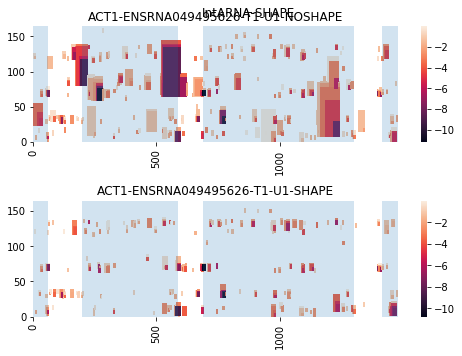

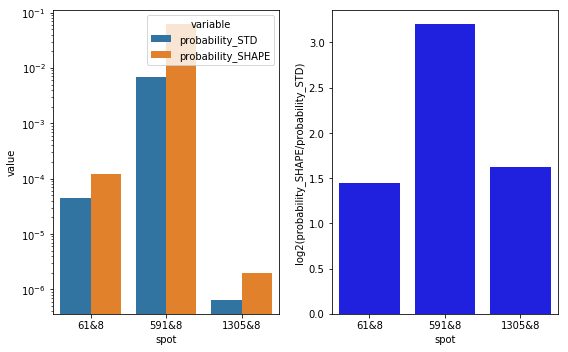

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=RPS9;'  > RPS9.gff
NC_003070.9	28157386	28159317	RPS9-0	1	-
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed RPS9.bed -fo RPS9-genomic.fa -s -name
bedtools getfasta on  RPS9-genomic.fa
[(116, 454), (1270, 1557)]
./IntaRNA/src/bin/IntaRNA --target=RPS9-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS9-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_RPS9-ENSRNA049495626-T1-U1.csv --out="spotProb:340&8:intarna-spotProbs_RPS9-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=RPS9-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS9-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --out=intarna-subopts_RPS9-ENSRNA049495626-T1-U1_INTARNASH

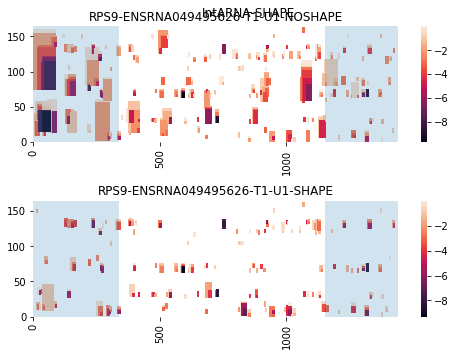

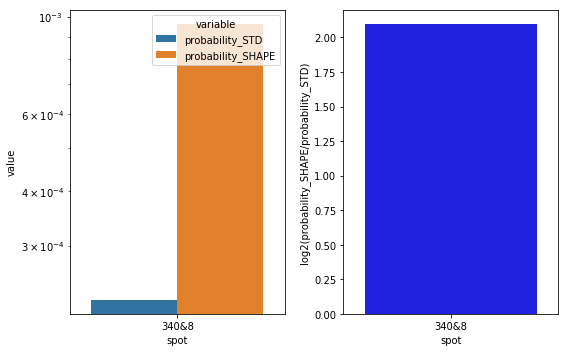

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=RPS10;'  > RPS10.gff
NC_003074.8	7885637	7886876	RPS10-0	1	+
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed RPS10.bed -fo RPS10-genomic.fa -s -name
bedtools getfasta on  RPS10-genomic.fa
[(101, 442), (594, 977)]
./IntaRNA/src/bin/IntaRNA --target=RPS10-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS10-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_RPS10-ENSRNA049495626-T1-U1.csv --out="spotProb:343&8:intarna-spotProbs_RPS10-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=RPS10-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS10-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --out=intarna-subopts_RPS10-ENSRNA049495626-T1-U1_

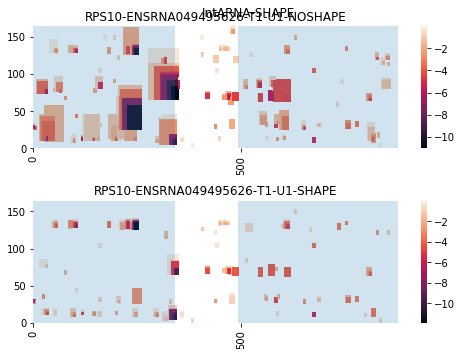

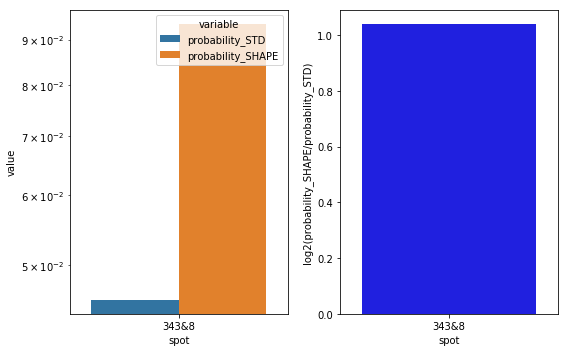

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=RPL16A;'  > RPL16A.gff
NC_003071.7	17791692	17793142	RPL16A-0	1	+
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed RPL16A.bed -fo RPL16A-genomic.fa -s -name
bedtools getfasta on  RPL16A-genomic.fa
[(103, 105), (184, 291), (378, 420), (767, 962), (1057, 1255)]
./IntaRNA/src/bin/IntaRNA --target=RPL16A-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPL16A-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_RPL16A-ENSRNA049495626-T1-U1.csv --out="spotProb:4&8,190&8,319&8,861&8:intarna-spotProbs_RPL16A-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=RPL16A-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPL16A-ENSRNA049495626-T1-U1_

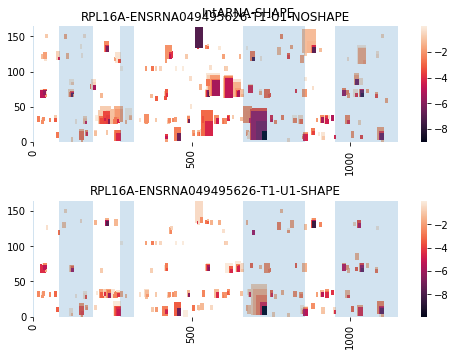

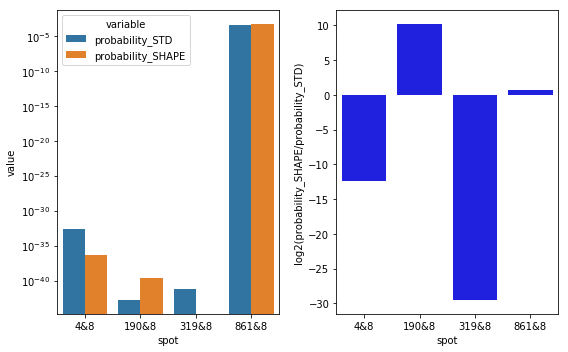

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=NBR1;'  > NBR1.gff
NC_003075.7	12741032	12744670	NBR1-0	1	+
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed NBR1.bed -fo NBR1-genomic.fa -s -name
bedtools getfasta on  NBR1-genomic.fa
[(160, 192), (551, 1440), (1530, 1653), (1757, 2014), (2192, 2341), (2434, 2991), (3070, 3171)]
./IntaRNA/src/bin/IntaRNA --target=NBR1-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_NBR1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_NBR1-ENSRNA049495626-T1-U1.csv --out="spotProb:34&8,1282&8,1495&8,1856&8,2183&8,2833&8:intarna-spotProbs_NBR1-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=NBR1-genomic.fa.CDS.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_

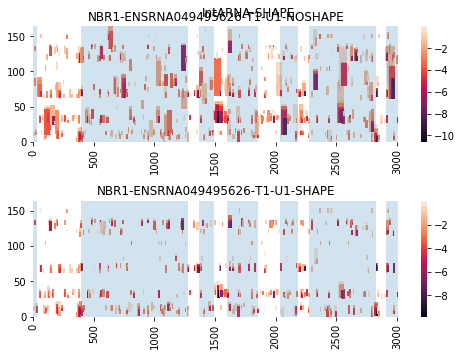

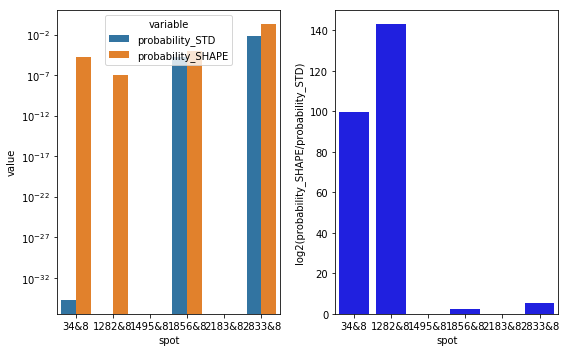

In [14]:
dfs_spotprobs_genes_CDS = list()

for gene in ['ACT1', 'RPS9', 'RPS10','RPL16A','NBR1',]:#'rps11','RPS11B',:
    df_spotprobs_gene = run_intarna_shape_for_a_gene(gene,CDS_only=True)
    dfs_spotprobs_genes_CDS.append(df_spotprobs_gene)
    plt.show()
df_spotprobs_genes_CDS = pd.concat(dfs_spotprobs_genes_CDS)  

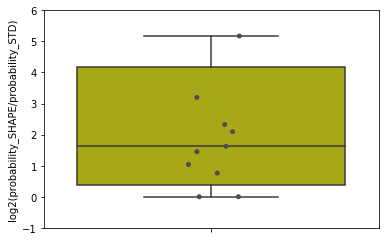

In [11]:
plot_aggregated_metrics(df_spotprobs_genes_CDS)

# mRNA with UTRs

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=ACT1;'  > ACT1.gff
NC_003071.7	15778941	15781561	ACT1-0	1	+
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed ACT1.bed -fo ACT1-genomic.fa -s -name
bedtools getfasta on  ACT1-genomic.fa
[(821, 880), (1017, 1410), (1511, 2124), (2236, 2301)]
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_ACT1-ENSRNA049495626-T1-U1.csv --out="spotProb:881&8,1411&8,2125&8:intarna-spotProbs_ACT1-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=ACT1-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_ACT1-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --out=intarna-subopts_ACT1-ENS

/home/milad/miniconda3/envs/intaSHAPE/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


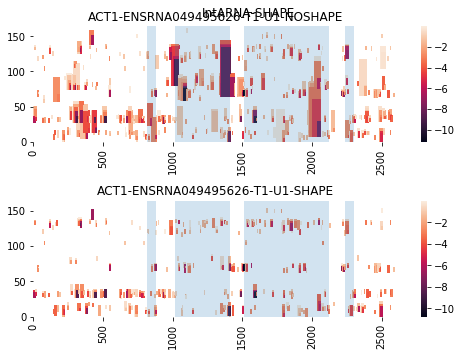

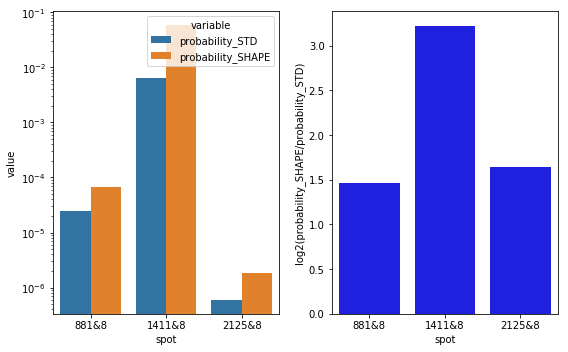

gunzip -c ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.gff.gz | grep 'gene=RPS9;'  > RPS9.gff
NC_003070.9	28157386	28159317	RPS9-0	1	-
bedtools getfasta -fi ../../../DataBase/TAIR/GCF_000001735.3_TAIR10_genomic.fna -bed RPS9.bed -fo RPS9-genomic.fa -s -name
bedtools getfasta on  RPS9-genomic.fa
[(116, 454), (1270, 1557)]
./IntaRNA/src/bin/IntaRNA --target=RPS9-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS9-ENSRNA049495626-T1-U1.csv --out=intarna-subopts_RPS9-ENSRNA049495626-T1-U1.csv --out="spotProb:455&8:intarna-spotProbs_RPS9-ENSRNA049495626-T1-U1.csv"  -n 20 --outOverlap=B --outMode=C --seedBP=5 --temperature 22  --qAccW 0 --qAccL 0  
b''
./IntaRNA/src/bin/IntaRNA --target=RPS9-genomic.fa --query=../data/2018010-U1-SHAPE/ENSRNA049495626/ENSRNA049495626-T1-U1.fa --out=pMinE:intarna-heatmap_RPS9-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --out=intarna-subopts_RPS9-ENSRNA049495626-T1-U1_INTARNASHAPE_.csv --qSh

KeyboardInterrupt: 

In [13]:
# dfs_spotprobs_genes = list()

# for gene in ['ACT1', 'RPS9', 'RPS10','RPL16A','NBR1',]:#'rps11','RPS11B',:
#     df_spotprobs_gene = run_intarna_shape_for_a_gene(gene,CDS_only=False)
#     dfs_spotprobs_genes.append(df_spotprobs_gene)
#     plt.show()
# df_spotprobs_genes = pd.concat(dfs_spotprobs_genes) 

In [ ]:
# plot_aggregated_metrics(df_spotprobs_genes)